# ATTENTION: noter que du fait de la taille des images, certaines cellules peuvent mettre beaucoup de temps à s'executer

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image, ImageOps
from tqdm import tqdm
import random

# Concernant les couleurs

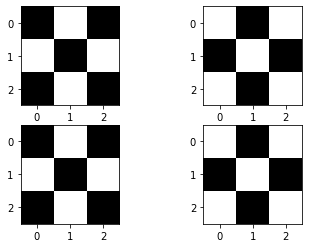

In [2]:
matrix_color = [np.array([[0,1,0],[1,0,1],[0,1,0]]),
                np.array([[1,0,1],[0,1,0],[1,0,1]]),
                np.array([[0,255,0],[255,0,255],[0,255,0]]),
                np.array([[255,0,255],[0,255,0],[255,0,255]])]
fig, axs = plt.subplots(2, 2)
axs[0,0].imshow(matrix_color[0], cmap = "gray") 
axs[0,1].imshow(matrix_color[1], cmap = "gray")
axs[1,0].imshow(matrix_color[2], cmap = "gray")
axs[1,1].imshow(matrix_color[3], cmap = "gray")
plt.show()

**Donc, il semble que**
* 0 = noir
* 1 (si 0/1) ou 255 (si 0/255) = blanc

# Fonctions

## Fonctions liées à l'ajout de gris à une image

In [3]:
def tograyscale(mat):
    """
    Scale les nombres de la matrice dans [0,255] (pour permettre les images en nuance de gris)
    Mais ne prend pas encore en compte le négatif
    """
    scaled_mat = 255.0 * mat / mat.max()
    #scaled_mat[scaled_mat<0] = 0 ?
    return scaled_mat

In [4]:
def to_binary(filename):
    """
    Importation de l'image, passage en nuance de gris, puis passage dans {0,1}
    """
    my_img = Image.open(filename)
    img_gray = ImageOps.grayscale(my_img) # Conversion en nuances de gris
    img_gray = np.array(img_gray)
    img_gray_binary = np.where(img_gray > 0.5, 1, 0) #Passage en binaire (méthodologie douteuse)
    return img_gray_binary


In [5]:
def noise(img, TAU, MU):
    """
    Ajout d'un bruit gaussien aux pixels de l'image
    """
    img_noised = np.zeros(shape = img.shape)
    row, col = np.shape(img)
    for i in range(row):
        for j in range(col):
            # ATTENTION: scale c'est l'écart type et pas la variance !
            img_noised[i,j] = np.random.normal(loc = MU[int(img[i,j])], scale = TAU)
    
    return img_noised

In [6]:
def create_noised_image(img, name, TAU, MU = [0,1]):
    """
    img = chemin vers l'image à bruiter
    name = suffixe de l'image bruitée enregistrée
    TAU = écart-type pour le bruit gaussien
    MU = moyenne pour le bruit gaussien MU[0] = 0, MU[1] = 1 par défaut donc bruit centré
    Pour faire un autre bruit MU[0] correspond au biais des pixels valant 0 dans l'image d'origine
    MU[1] correspond au biais valant 1 dans l'image d'origine
    """
    
    img_bin = to_binary(img) # Vu que l'image originale doit être dans [0,1], on force les pixels à ne valoir qu'une 
    # seule de ces valeurs
    img_bin_noised = noise(img_bin, TAU, MU)
    plt.imshow(img_bin_noised, cmap = "gray")
    
    tosave = Image.fromarray(tograyscale(img_bin_noised))
    #tosave.convert("L").save("data/"+str(name)+"_TAU="+str(TAU)+".png")
    img_name = "data/"+str(name)+"_TAU="+str(TAU)+ "_MU="+str(MU[0])+"_"+str(MU[1])+".png"
    print(img_name)
    tosave.convert("L").save(img_name)

## Fonctions liées au gibbs sampling à propos parlé

In [7]:
def sample(i, j, X, Y, maxi, maxj, ALPHA, BETA, TAU, MU):
    """
    Echantillonne dans la distribution conditionnelle pour un pixel
    """
   
    # Ajout des valeurs des 4 voisins du pixel considéré, si pertinent
    voisins = []
    if i != 0:
        voisins.append(X[i-1][j])
    if i!= maxi-1:
        voisins.append(X[i+1][j])
    if j!= 0:
        voisins.append(X[i][j-1])
    if j!= maxj-1:
        voisins.append(X[i][j+1])
        
    # Calcul du nombre de 0 et de 1 dans les voisins
    nb_0 = sum(voisins[i] == 0 for i in range(len(voisins)))
    nb_1 = sum(voisins[i] == 1 for i in range(len(voisins)))
    
    # Prise en considération de la variation du nombre de voisins (bords)
    pond = 4/len(voisins) 
    
    # Calcul de la probabilité de valoir 1
    exp_valeur_1 = -ALPHA + BETA * pond * (nb_0-nb_1) + 1/(2*(TAU**2))*(MU[1]**2 - MU[0]**2 + 2*Y[i][j]*(MU[0]-MU[1]))
    
    # Calcul de la probabilité de valoir 0 (juste pour vérifier)
    #exp_valeur_0 = ALPHA + BETA * pond * (nb_1-nb_0) + 1/(2*(TAU**2))*(MU[0]**2 - MU[1]**2 + 2*Y[i][j]*(MU[1]-MU[0]))
    #print(1/(1+np.exp(exp_valeur_1)) + 1/(1+np.exp(exp_valeur_0)))
    #print(1/(1+np.exp(exp_valeur_0)))
    
    prob = 1/(1+np.exp(exp_valeur_1))
    
    # Renvoie 1 si l'uniforme est inférieure à la proba de valoir 1
    U = np.random.rand()
    return(int(U < prob)) 

In [34]:
def get_posterior(filename0, filename, burn_in, samples, ALPHA, BETA, TAU, deter = True, MU = [0.0,1.0]):
    """
    Output les fréquences de valoir 1 pour chaque pixel
    Par défaut mu vaut [0,1] donc pas de biais
    
    Attention, ici l'image qu'on ouvre doit bien être enregistrée en nuances de gris !
    """
    
    im_open = Image.open(filename)
    Y = np.array(im_open)
    im_open.close()
    
    # Vérification que l'image est bien en nuances de gris ("2D")
    if len(Y.shape) != 2: 
        print("Erreur: l'image n'est pas en nuances de gris")
        return False
    Y = Y / 255.0 # Puisque le bruitage a été fait dans [0,1], le débruitage doit l'être aussi
    
    
    # Initialisation
    posterior = np.zeros(Y.shape) #Sortie
    
    X = np.random.choice([1,0], size = Y.shape) # Matrice X
    X_prior = X.copy() # Sauvegarde pour l'affichage plus bas
    
    maxi = Y.shape[0]
    maxj = Y.shape[1]
    pairs = []
    
    for i in range(maxi):
        for j in range(maxj):
            pairs.append((i,j))
    
    # On suit un pixel aléatoire pour vérifier la convergence
    num_ran = random.randint(0, maxi*maxj-1)
    pixel = pairs[num_ran]
    suivi_pixel = []
    
    
    
    for step in tqdm(range(burn_in + samples)):
        
        # On parcourt les pixels de manière déterministe (toujours la même)
        if deter:
            for i in range(maxi):
                for j in range(maxj):
                    x = sample(i, j, X, Y, maxi, maxj, ALPHA, BETA, TAU, MU)
                    X[i,j] = x
                    if x == 1 and step >= burn_in:
                        posterior[i][j] += 1
                        
        # On parcourt les pixels de manière aléatoire
        else:
            random.shuffle(pairs) # On mélange la liste de pairs 
            for i,j in pairs:
                x = sample(i, j, X, Y, maxi, maxj, ALPHA, BETA, TAU, MU)
                X[i,j] = x
                if x == 1 and step >= burn_in:
                    posterior[i][j] += 1.0
            
        suivi_pixel.append(X[pixel])
    
    # On a ajouté 1 aux pixels à chaque itération réelle où il valait 1
    # On divise par le nombre de samples pour avoir une fréquence
    posterior = posterior / samples
    
    fig, axs = plt.subplots(1, 5, figsize = (10,2))
    img_init = mpimg.imread(filename0)
    axs[0].imshow(img_init, cmap = "gray") 
    axs[0].set_title("Image d'origine")
    axs[1].imshow(Y, cmap = "gray") 
    axs[1].set_title("Image bruitée")
    axs[2].imshow(X_prior, cmap = "gray")
    axs[2].set_title("Prior aléatoire")
    axs[3].imshow(posterior, cmap = "gray")
    axs[3].set_title("Posterior")
    axs[4].scatter([i for i in range(0, len(suivi_pixel))],
        suivi_pixel, s = 2, marker = '')
    axs[4].set_title("Suivi pixel aléatoire")
    
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.6, 
                    hspace=0.05)
    
    plt.show()

    return posterior

In [12]:
def posterior_to_binary(posterior, seuil):
    """
    Transforme notre posterior en nuances de gris en un posterior en noir et blanc
    Tout pixel valant 1 a une fréquence supérieure au seuil est considéré comme valant 1
    """
    
    if seuil < 0 or seuil > 1.0:
        print("Erreur: le seuil choisi ne correspond pas à une fréquence")
        return False 
    
    # On remplit l'image de blanc
    posterior_nb = np.ones(posterior.shape, dtype = np.float64)
    
    # On met des pixels noirs là où ils sont très peu souvent blancs
    # Comme on relève la fréquence des pixels blancs, il faut qu'on soit inférieur à un seuil
    # Cad qu'on met noirs les pixels très peu souvent blancs
    posterior_nb[posterior < seuil] = 0
    
    plt.imshow(posterior_nb, cmap = "gray")
    plt.show()
    
    return posterior_nb

# Tests

## Voici les images que nous allons bruiter puis débruiter

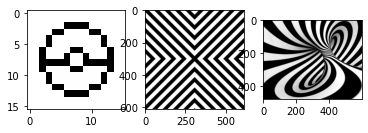

In [13]:
f, axarr = plt.subplots(1,3)
img = mpimg.imread("data/poke.png")
img2 = mpimg.imread("data/triangle.png")
img3 = mpimg.imread("data/spirale.png")
axarr[0].imshow(img, cmap="gray")
axarr[1].imshow(img2, cmap="gray")
axarr[2].imshow(img3, cmap="gray")
plt.show()

# Bruitage d'une image

**Bien se rappeler que tau correspond à l'écart-type et non pas à la variance !!**

Le nom de l'image contient la valeur de tau et les valeurs de mu

## Images sans biais

data/poke_noise_TAU=0.1_MU=0_1.png


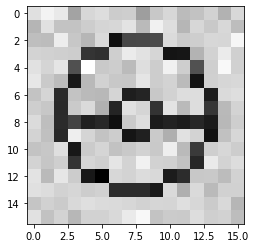

data/triangle_noise_TAU=0.1_MU=0_1.png


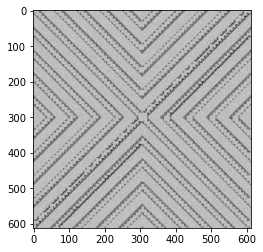

data/spirale_noise_TAU=0.1_MU=0_1.png


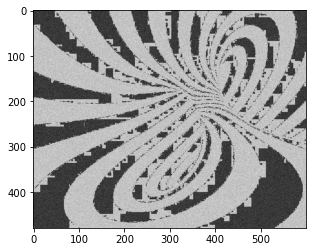

In [14]:
create_noised_image("data/poke.png", "poke_noise", TAU= 0.1)
plt.show()
create_noised_image("data/triangle.png", "triangle_noise", TAU= 0.1)
plt.show()
create_noised_image("data/spirale.png", "spirale_noise", TAU= 0.1)
plt.show()

data/poke_noise_TAU=0.2_MU=0_1.png


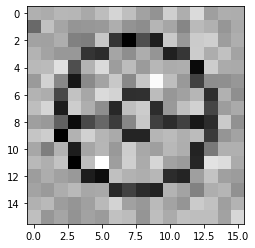

data/triangle_noise_TAU=0.2_MU=0_1.png


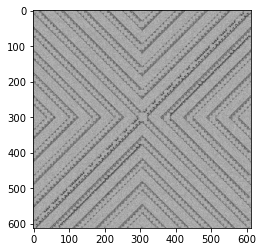

data/spirale_noise_TAU=0.2_MU=0_1.png


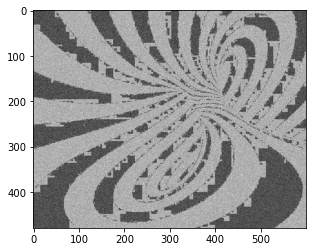

In [15]:
create_noised_image("data/poke.png", "poke_noise", TAU= 0.2)
plt.show()
create_noised_image("data/triangle.png", "triangle_noise", TAU= 0.2)
plt.show()
create_noised_image("data/spirale.png", "spirale_noise", TAU= 0.2)
plt.show()

data/poke_noise_TAU=0.4_MU=0_1.png


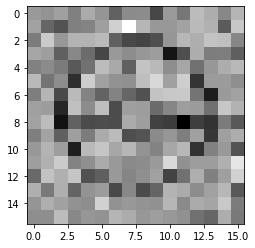

data/triangle_noise_TAU=0.4_MU=0_1.png


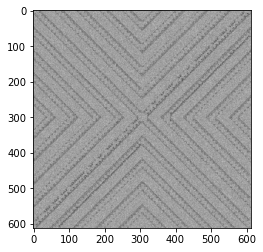

data/spirale_noise_TAU=0.4_MU=0_1.png


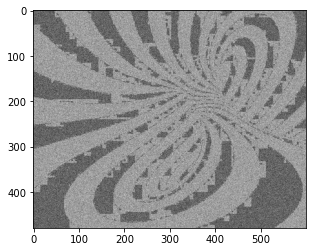

In [16]:
create_noised_image("data/poke.png", "poke_noise", TAU= 0.4)
plt.show()
create_noised_image("data/triangle.png", "triangle_noise", TAU= 0.4)
plt.show()
create_noised_image("data/spirale.png", "spirale_noise", TAU= 0.4)
plt.show()

## Images avec biais

data/poke_noise_TAU=0.1_MU=0.1_1.png


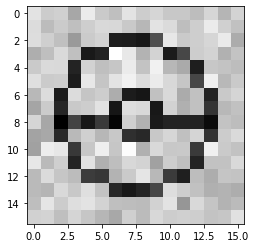

data/triangle_noise_TAU=0.1_MU=0.1_1.png


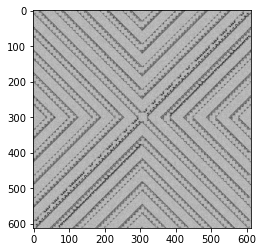

data/spirale_noise_TAU=0.1_MU=0.1_1.png


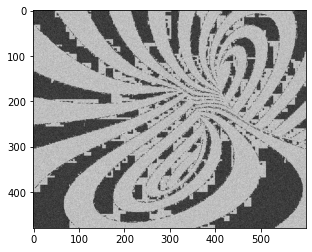

In [17]:
create_noised_image("data/poke.png", "poke_noise", TAU= 0.1, MU = [0.1,1])
plt.show()
create_noised_image("data/triangle.png", "triangle_noise", TAU= 0.1, MU = [0.1,1])
plt.show()
create_noised_image("data/spirale.png", "spirale_noise", TAU= 0.1, MU = [0.1,1])
plt.show()

data/poke_noise_TAU=0.1_MU=0.2_1.png


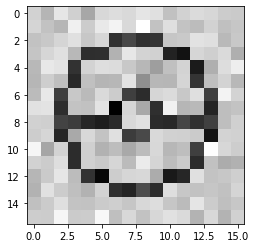

data/triangle_noise_TAU=0.1_MU=0.2_1.png


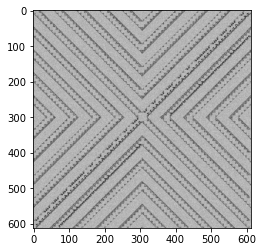

data/spirale_noise_TAU=0.1_MU=0.2_1.png


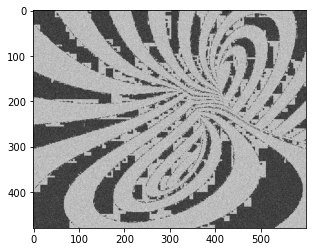

In [18]:
create_noised_image("data/poke.png", "poke_noise", TAU= 0.1, MU = [0.2,1])
plt.show()
create_noised_image("data/triangle.png", "triangle_noise", TAU= 0.1, MU = [0.2,1])
plt.show()
create_noised_image("data/spirale.png", "spirale_noise", TAU= 0.1, MU = [0.2,1])
plt.show()

data/poke_noise_TAU=0.1_MU=0.5_1.png


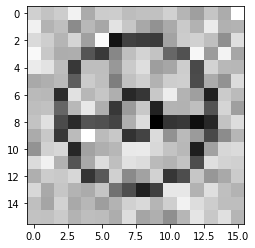

data/triangle_noise_TAU=0.1_MU=0.5_1.png


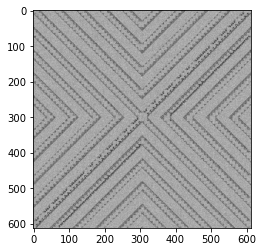

data/spirale_noise_TAU=0.1_MU=0.5_1.png


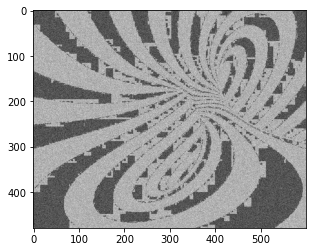

In [19]:
create_noised_image("data/poke.png", "poke_noise", TAU= 0.1, MU = [0.5,1])
plt.show()
create_noised_image("data/triangle.png", "triangle_noise", TAU= 0.1, MU = [0.5,1])
plt.show()
create_noised_image("data/spirale.png", "spirale_noise", TAU= 0.1, MU = [0.5,1])
plt.show()

data/poke_noise_TAU=0.1_MU=0.3_0.7.png


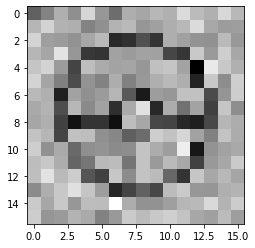

data/triangle_noise_TAU=0.1_MU=0.3_0.7.png


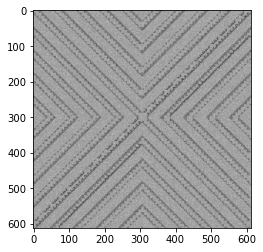

data/spirale_noise_TAU=0.1_MU=0.3_0.7.png


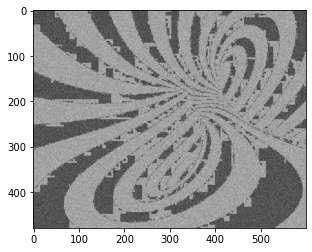

In [20]:
create_noised_image("data/poke.png", "poke_noise", TAU= 0.1, MU = [0.3,0.7])
plt.show()
create_noised_image("data/triangle.png", "triangle_noise", TAU= 0.1, MU = [0.3,0.7])
plt.show()
create_noised_image("data/spirale.png", "spirale_noise", TAU= 0.1, MU = [0.3,0.7])
plt.show()

# Q1 - Tentative de débruitage

## Images sans biais

Avec un écart-type de 0.1, on arrive à débruiter en une seule étape

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.32it/s]


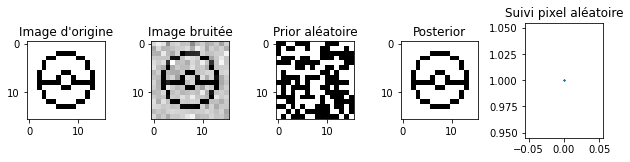

In [48]:
posterior_poke = get_posterior("data/poke.png", "data/poke_noise_TAU=0.1_MU=0_1.png", 0, 1, ALPHA = 1e-5, 
                               BETA = 0.2, TAU = 0.1, deter = True)
plt.show()

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.33it/s]


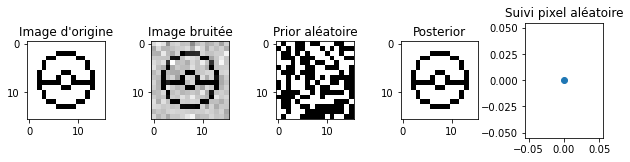

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:45<00:00, 45.20s/it]


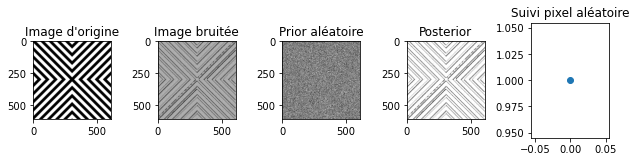

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:29<00:00, 29.03s/it]


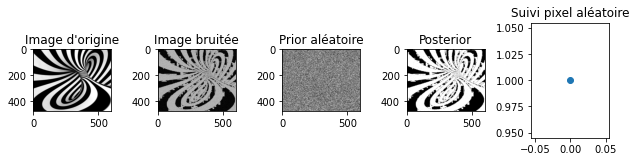

In [26]:
posterior_triangle = get_posterior("data/triangle.png","data/triangle_noise_TAU=0.1_MU=0_1.png", 0, 1, ALPHA = 1e-5, BETA = 0.2, TAU = 0.1, 
                          deter = True)
plt.show()
posterior_spirale = get_posterior("data/spirale.png","data/spirale_noise_TAU=0.1_MU=0_1.png", 0, 1, ALPHA = 1e-5, BETA = 0.2, TAU = 0.1, 
                          deter = True)
plt.show()

Avec un écart type plus élevé, ça se complique 

100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:02<00:00, 51.62it/s]


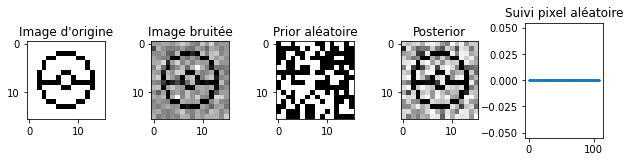

In [49]:
posterior_poke_tau_eleve = get_posterior("data/poke.png","data/poke_noise_TAU=0.2_MU=0_1.png", 10, 100, ALPHA = 0.01, BETA = 0.01, TAU = 0.3, 
                          deter = False)
plt.show()

100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:02<00:00, 43.19it/s]


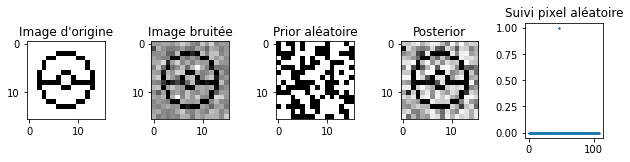

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:13<00:00, 36.92s/it]


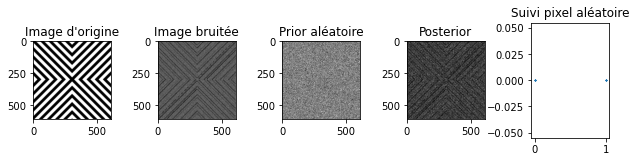

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:55<00:00, 27.54s/it]


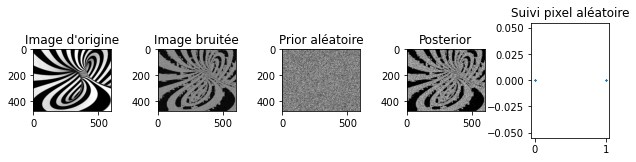

In [37]:
posterior_triangle_tau_eleve = get_posterior("data/triangle.png","data/triangle_noise_TAU=0.4_MU=0_1.png", 0, 2, ALPHA = 0.01, BETA = 0.01, TAU = 0.3, 
                          deter = False)
plt.show()
posterior_spirale_tau_eleve = get_posterior("data/spirale.png","data/spirale_noise_TAU=0.2_MU=0_1.png", 0, 2, ALPHA = 0.01, BETA = 0.01, TAU = 0.3, 
                          deter = False)
plt.show()

Mais en filtrant les probas selon un seuil, on peut quand même retrouver l'image de base ! 
Ici, les pixels noirs sont les pixels qui ne sont pas blancs 99% du temps

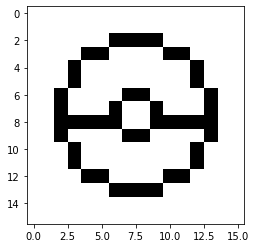

In [50]:
post_nb = posterior_to_binary(posterior_poke_tau_eleve, seuil = 0.1)
plt.show()

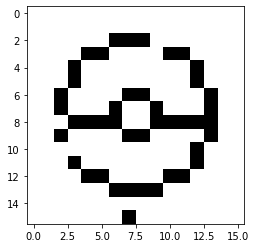

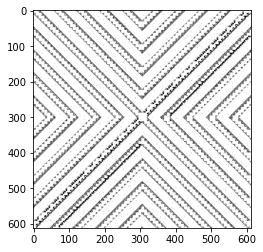

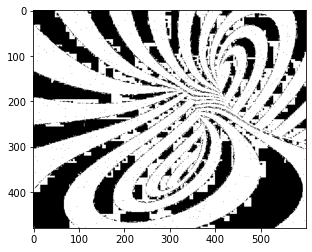

In [34]:
post_nb2 = posterior_to_binary(posterior_triangle, seuil = 0.1)
plt.show()
post_nb3 = posterior_to_binary(posterior_spirale, seuil = 0.1)
plt.show()

Pour un écart-type de 0.4, ca se complique encore. On arrive à l'image générale mais pas exacte

100%|██████████████████████████████████████████████████████████████████████████████| 1100/1100 [00:19<00:00, 55.14it/s]


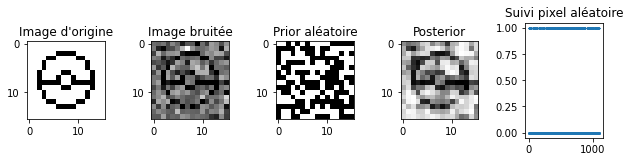

In [52]:
posterior_poke_tau_fort = get_posterior("data/poke.png","data/poke_noise_TAU=0.4_MU=0_1.png", 1000, 100, ALPHA = 1.0, BETA = 0.6, TAU = 0.4, deter = False)
plt.show()

100%|██████████| 11000/11000 [01:10<00:00, 156.05it/s]


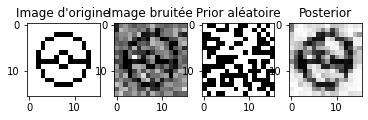

100%|██████████| 15/15 [02:31<00:00, 10.07s/it]


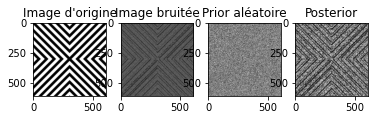

100%|██████████| 15/15 [01:52<00:00,  7.50s/it]


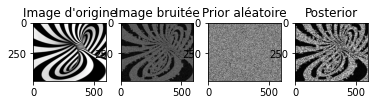

In [43]:
posterior_triangle_tau_fort = get_posterior("data/triangle.png","data/triangle_noise_TAU=0.4_MU=0_1.png", 5, 10, ALPHA = 1.0, BETA = 0.6, TAU = 0.4, deter = False)
plt.show()
posterior_spirale_tau_fort = get_posterior("data/spirale.png","data/spirale_noise_TAU=0.4_MU=0_1.png", 5, 10, ALPHA = 1.0, BETA = 0.6, TAU = 0.4, deter = False)
plt.show()

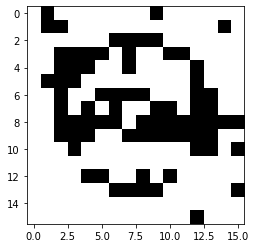

In [53]:
post_nb3 = posterior_to_binary(posterior_poke_tau_fort, seuil = 0.5)
plt.show()

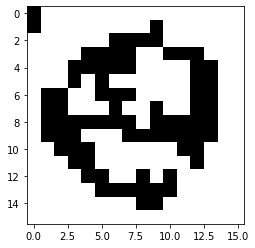

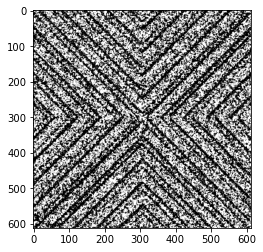

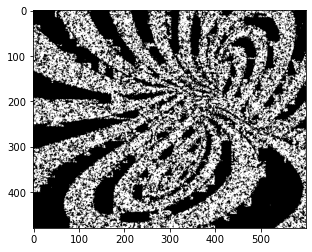

In [50]:
post_nb4 = posterior_to_binary(posterior_triangle_tau_fort, seuil = 0.5)
plt.show()
post_nb5 = posterior_to_binary(posterior_spirale_tau_fort, seuil = 0.5)
plt.show()

## Images avec biais

Avec un biais faible sur la vraie valeur du pixel noir (0.1) et la même variance que précédemment, pas de problème

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:49<00:00, 40.52it/s]


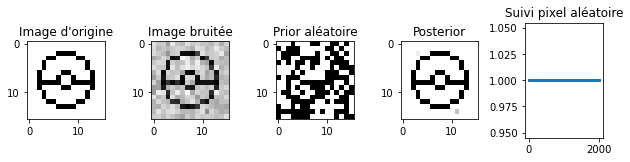

In [54]:
posterior_biais_poke = get_posterior("data/poke.png","data/poke_noise_TAU=0.1_MU=0.1_1.png", 1000, 1000, ALPHA = 0.1, BETA = 0.1, 
                          TAU = 0.1, MU = [0.1, 1],deter = True)
plt.show()

100%|██████████| 2000/2000 [00:12<00:00, 154.92it/s]


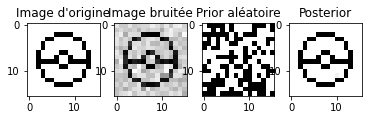

100%|██████████| 15/15 [02:25<00:00,  9.71s/it]


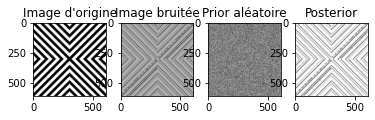

100%|██████████| 15/15 [01:48<00:00,  7.22s/it]


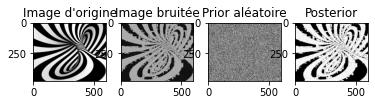

In [51]:
posterior_biais_triangle = get_posterior("data/triangle.png","data/triangle_noise_TAU=0.1_MU=0.1_1.png", 5, 10, ALPHA = 0.1, BETA = 0.1, 
                          TAU = 0.1, MU = [0.1, 1],deter = True)
plt.show()
posterior_biais_spirale = get_posterior("data/spirale.png","data/spirale_noise_TAU=0.1_MU=0.1_1.png", 5, 10, ALPHA = 0.1, BETA = 0.1, 
                          TAU = 0.1, MU = [0.1, 1],deter = True)
plt.show()

Avec un biais intermédiaire sur la vraie valeur du pixel noir : 0.25

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:57<00:00, 35.03it/s]


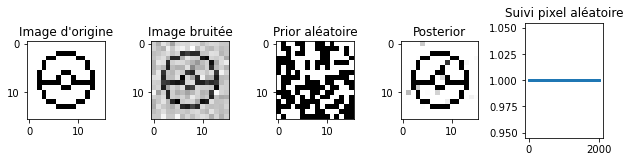

In [55]:
posterior_biais_int_poke = get_posterior("data/poke.png","data/poke_noise_TAU=0.1_MU=0.2_1.png", 1000, 1000, ALPHA = 0.1, BETA = 0.1, 
                          TAU = 0.1, MU = [0.25, 1],deter = True)
plt.show()

100%|██████████| 2000/2000 [00:13<00:00, 145.46it/s]


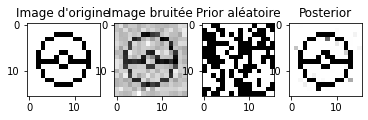

100%|██████████| 15/15 [02:29<00:00,  9.99s/it]


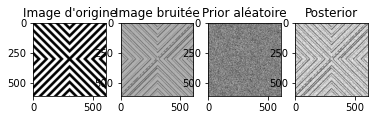

100%|██████████| 15/15 [01:53<00:00,  7.59s/it]


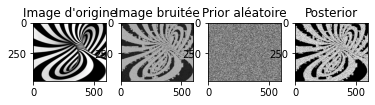

In [52]:
posterior_biais_int_triangle = get_posterior("data/triangle.png","data/triangle_noise_TAU=0.1_MU=0.2_1.png", 5, 10, ALPHA = 0.1, BETA = 0.1, 
                          TAU = 0.1, MU = [0.25, 1],deter = True)
plt.show()
posterior_biais_int_spirale = get_posterior("data/spirale.png","data/spirale_noise_TAU=0.1_MU=0.2_1.png", 5, 10, ALPHA = 0.1, BETA = 0.1, 
                          TAU = 0.1, MU = [0.25, 1],deter = True)
plt.show()

Pour un biais plus élevé et réparti sur les deux pixels, on obtient les résultats suivants, beaucoup moins convaincants:

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:39<00:00, 50.40it/s]


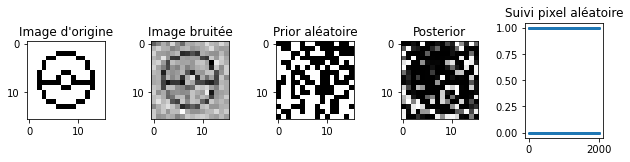

In [56]:
posterior_biais_fort_poke = get_posterior("data/poke.png","data/poke_noise_TAU=0.1_MU=0.3_0.7.png", 1000, 1000, ALPHA = 0.1, BETA = 0.1, 
                          TAU = 0.1, MU = [0.5, 1],deter = True)
plt.show()

100%|██████████| 2000/2000 [00:12<00:00, 158.88it/s]


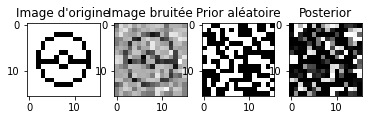

100%|██████████| 15/15 [02:23<00:00,  9.55s/it]


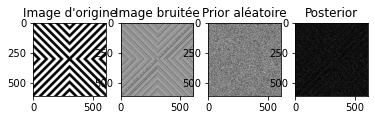

100%|██████████| 15/15 [01:49<00:00,  7.30s/it]


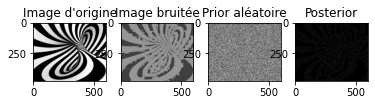

In [55]:
posterior_biais_fort_triangle = get_posterior("data/triangle.png","data/triangle_noise_TAU=0.1_MU=0.3_0.7.png", 5, 10, ALPHA = 0.1, BETA = 0.1, 
                          TAU = 0.1, MU = [0.5, 1],deter = True)
plt.show()
posterior_biais_fort_spirale = get_posterior("data/spirale.png","data/spirale_noise_TAU=0.1_MU=0.3_0.7.png", 5, 10, ALPHA = 0.1, BETA = 0.1, 
                          TAU = 0.1, MU = [0.5, 1],deter = True)
plt.show()

**Etrangement, il semble que si on prend une image biaisé avec un biais élevé et qu'on la débruite avec un biais considéré plus faible, cela marche plutot bien**
On prend l'image bruitée avec un biais de 0.5 sur le pixel noir, et on la débruite avec un biais de 0.1 sur ce même pixel

--> Cela m'amène à douter concernant les algos mis en place

Peut-être que là le passage par [0,1] crée des problèmes ?

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:44<00:00, 45.09it/s]


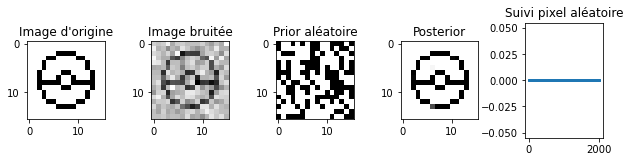

In [57]:
posterior_decale_poke = get_posterior("data/poke.png","data/poke_noise_TAU=0.1_MU=0.5_1.png", 1000, 1000, ALPHA = 0.1, BETA = 0.1, 
                          TAU = 0.1, MU = [0.1, 1],deter = True)
plt.show()

100%|██████████| 2000/2000 [00:12<00:00, 162.68it/s]


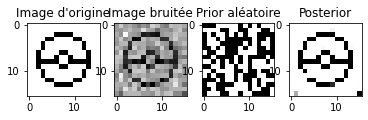

100%|██████████| 15/15 [02:20<00:00,  9.38s/it]


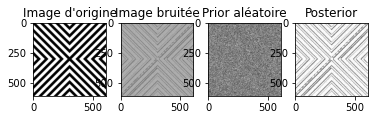

100%|██████████| 15/15 [01:48<00:00,  7.26s/it]


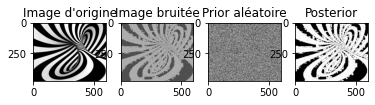

In [61]:
posterior_decale_triangle = get_posterior("data/triangle.png","data/triangle_noise_TAU=0.1_MU=0.5_1.png", 5, 10, ALPHA = 0.1, BETA = 0.1, 
                          TAU = 0.1, MU = [0.1, 1],deter = True)
plt.show()
posterior_decale_spirale = get_posterior("data/spirale.png","data/spirale_noise_TAU=0.1_MU=0.5_1.png", 5, 10, ALPHA = 0.1, BETA = 0.1, 
                          TAU = 0.1, MU = [0.1, 1],deter = True)
plt.show()

# Question 2

In [38]:
from scipy.stats import invgamma
from statsmodels.graphics.tsaplots import plot_acf

## Concernant la loi inverse gamma dans scipy.stats

* Scale = beta
* a = alpha

Pour avoir une invgamma($\alpha$, $\beta$) classique, utiliser donc:
invgamma(a = alpha, loc = 0, scale = beta)

## Fonctions

In [39]:
def sample_TAU(X, Y, maxi, maxj, TAU, MU, a, b):
    
    X_mu = np.zeros(shape = Y.shape)
    
    ##### Techniquement il faudrait remplacer chaque élément de X par la valeur correspondante du vecteur MU
    # Ici je garde MU[0] = 0 et MU[1] = 1 donc osef mais il faudra le changer 
    # Et j'imagine qu'on peut le faire d'une facon plus efficace que juste boucler sur tous les pixels
    
    somme = ((Y - X)**2).sum()
    
    a = a + (maxi*maxj)
    b = b + 1/2* somme
    TAU2 = invgamma.rvs(a = a, scale = b)
    
    return np.sqrt(TAU2), a, b

In [46]:
def get_posterior2(filename0,filename, burn_in, samples, ALPHA, BETA, deter = True, MU = [0.0,1.0]):
    """
    Output les fréquences de valoir 1 pour chaque pixel
    Par défaut mu vaut [0,1] donc pas de biais
    
    Attention, ici l'image qu'on ouvre doit bien être enregistrée en nuances de gris !
    """
    
    im_open = Image.open(filename)
    Y = np.array(im_open)
    im_open.close()
    
    # Vérification que l'image est bien en nuances de gris ("2D")
    if len(Y.shape) != 2: 
        print("Erreur: l'image n'est pas en nuances de gris")
        return False
    Y = Y / 255.0 # Puisque le bruitage a été fait dans [0,1], le débruitage doit l'être aussi
    
    
    # Initialisation
    posterior = np.zeros(Y.shape) #Sortie
    X = np.random.choice([1,0], size = Y.shape) # Matrice X
    X_prior = X.copy() # Sauvegarde pour l'affichage plus bas
    
    a = 2 
    b = 0.5
    TAU2 = invgamma.rvs(a = a, scale = b) # On tire dans une inverse gamma pour le prior de TAU2
    TAU = np.sqrt(TAU2)
    #print(TAU)
    TAUS = [] # Liste pour vérifier la convergence de TAU
  
    maxi = Y.shape[0]
    maxj = Y.shape[1]
    pairs = []
    
    for i in range(maxi):
        for j in range(maxj):
            pairs.append((i,j))
    
    
    for step in tqdm(range(burn_in + samples)):
        
        # On parcourt les pixels de manière déterministe (toujours la même)
        if deter:
            for i in range(maxi):
                for j in range(maxj):
                    x = sample(i, j, X, Y, maxi, maxj, ALPHA, BETA, TAU, MU)
                    X[i,j] = x
                    if x == 1 and step >= burn_in:
                        posterior[i][j] += 1
                     
        # On parcourt les pixels de manière aléatoire
        else:
            random.shuffle(pairs) # On mélange la liste de pairs 
            for i,j in pairs:
                x = sample(i, j, X, Y, maxi, maxj, ALPHA, BETA, TAU, MU)
                X[i,j] = x
                if x == 1 and step >= burn_in:
                    posterior[i][j] += 1.0
        
        # Mise à jour de TAU
        TAU, a, b = sample_TAU(X, Y, maxi, maxj, TAU, MU, a, b)
        if step >= burn_in:
            TAUS.append(TAU)
            
        #Mise à jour d'un pixel 
            #A completer 
            
    
    # On a ajouté 1 aux pixels à chaque itération réelle où il valait 1
    # On fait la moyenne
    posterior = posterior / samples

    fig, axs = plt.subplots(2, 3, figsize=(10,10))
    img_init = mpimg.imread(filename0)
    axs[0,0].imshow(img_init, cmap = "gray") 
    axs[0,0].set_title("Image d'origine")
    axs[0,1].imshow(Y, cmap = "gray") 
    axs[0,1].set_title("Image bruitée")
    axs[0,2].imshow(X_prior, cmap = "gray")
    axs[0,2].set_title("Prior aléatoire")
    axs[1,0].imshow(posterior, cmap = "gray")
    axs[1,0].set_title("Posterior")
    axs[1,1].plot(TAUS)
    axs[1,1].set_title("Valeur de tau")
    
    # Si on a trop peu de points, on ne peut pas calculer autant de lags
    if samples <= 10:
        lags = samples - 1
    else:
        lags = 10
        
    plot_acf(np.array(TAUS), lags = lags, ax = axs[1,2])
    axs[1,2].set_title("Autocorrélation de tau")
    
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.6, 
                    hspace=0.05)
    plt.show()
    
    print(np.mean(TAUS))
    return posterior

100%|██████████████████████████████████████████████████████████████████████████████| 1100/1100 [00:27<00:00, 40.63it/s]


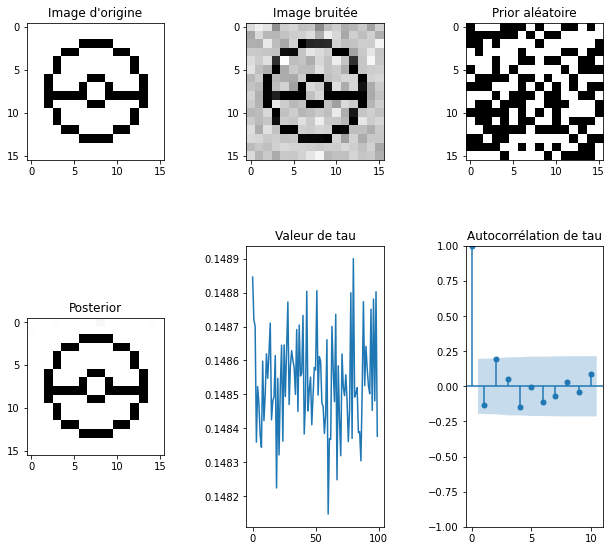

0.14853577418523276


In [41]:
posterior_qst2_poke = get_posterior2("data/poke.png","data/poke_noise_TAU=0.1_MU=0_1.png", 1000, 100, ALPHA = 0.2, BETA = 0.2,  
                          deter = True)
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████| 1100/1100 [00:28<00:00, 38.25it/s]


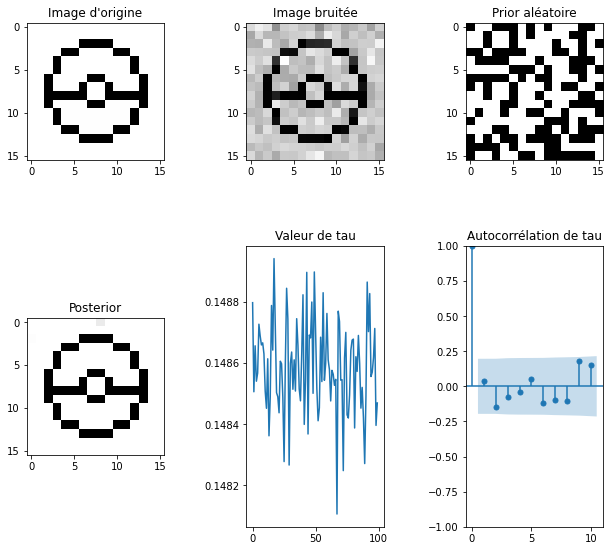

0.14858537852805986


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [08:14<00:00, 33.00s/it]


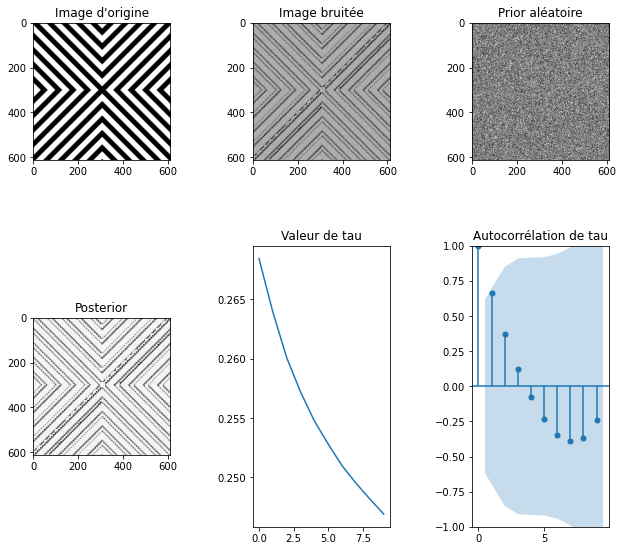

  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

0.2552822804763356


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [07:14<00:00, 28.97s/it]


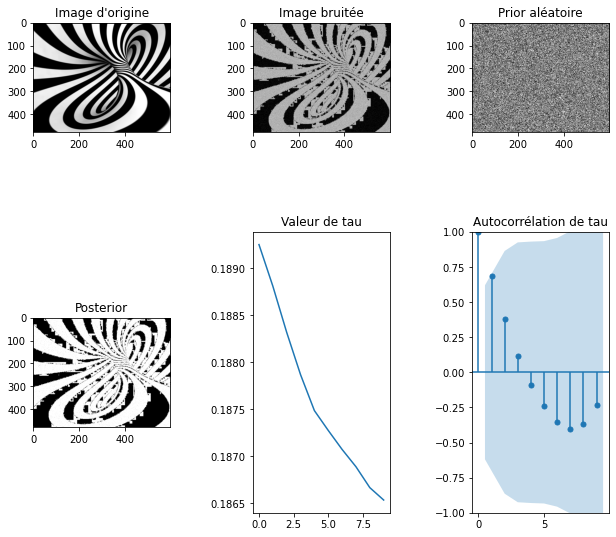

0.18761651462589202


In [47]:
posterior_qst2_poke = get_posterior2("data/poke.png","data/poke_noise_TAU=0.1_MU=0_1.png", 1000, 100, ALPHA = 0.2, BETA = 0.2,  
                          deter = True)
plt.show()
posterior_qst2_triangle = get_posterior2("data/triangle.png","data/triangle_noise_TAU=0.1_MU=0_1.png", 5, 10, ALPHA = 0.2, BETA = 0.2,  
                          deter = True)
plt.show()
posterior_qst2_spirale = get_posterior2("data/spirale.png","data/spirale_noise_TAU=0.1_MU=0_1.png", 5, 10, ALPHA = 0.2, BETA = 0.2,  
                          deter = True)
plt.show()

100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:02<00:00, 46.24it/s]


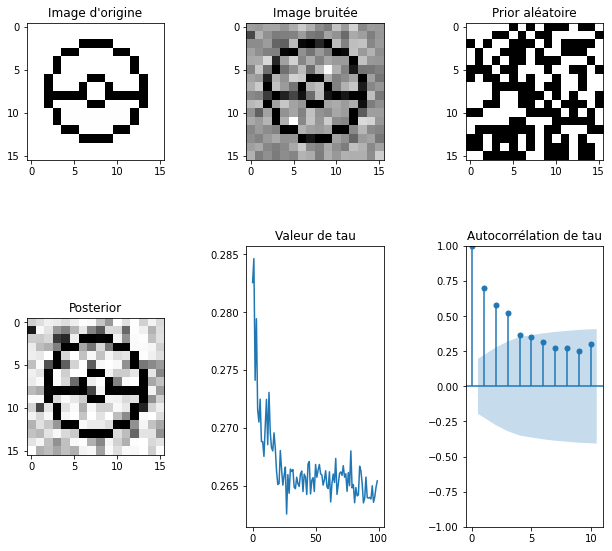

0.2666551823305385


In [58]:
posterior_qst2_poke_taux_int = get_posterior2("data/poke.png","data/poke_noise_TAU=0.2_MU=0_1.png", 1, 100, ALPHA = 0.2, BETA = 0.2,  
                          deter = True)
plt.show()

100%|██████████| 1100/1100 [00:07<00:00, 154.65it/s]


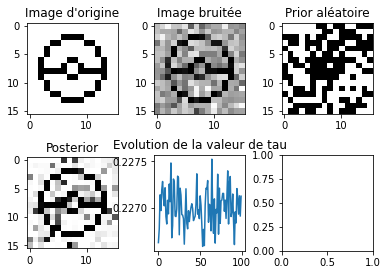

0.2270051703493079


100%|██████████| 15/15 [02:26<00:00,  9.76s/it]


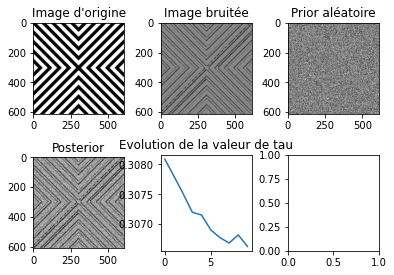

0.30715685205237286


100%|██████████| 15/15 [01:57<00:00,  7.82s/it]


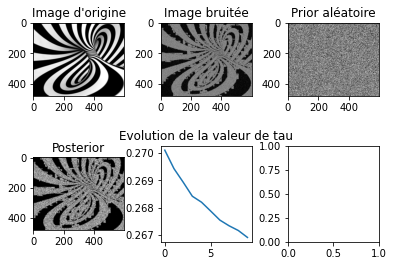

0.26819437252998685


In [68]:
posterior_qst2_triangle_taux_int = get_posterior2("data/triangle.png","data/triangle_noise_TAU=0.2_MU=0_1.png", 5, 10, ALPHA = 0.2, BETA = 0.2,  
                          deter = True)
plt.show()
posterior_qst2_spirale_taux_int = get_posterior2("data/spirale.png","data/spirale_noise_TAU=0.2_MU=0_1.png", 5, 10, ALPHA = 0.2, BETA = 0.2,  
                          deter = True)
plt.show()

De mes expériences, je retiens que:

* On retrouve relativement bien l'image de base

* On ne retombe pas tout à fait sur l'écart-type d'origine (et changer $\alpha$ ou $\beta$ ne semble pas régler le problème)